<a href="https://colab.research.google.com/github/tnichlani/Deep_Learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning**

Download and unzip dataset

In [7]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-covid-19/keras-covid-19.zip
!unzip -qq keras-covid-19.zip
%cd keras-covid-19

--2021-07-20 06:04:39--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-covid-19/keras-covid-19.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.229.8
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.229.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67536764 (64M) [application/zip]
Saving to: ‘keras-covid-19.zip’

keras-covid-19.zip  100%[===================>]  64.41M  26.3MB/s    in 2.4s    

2021-07-20 06:04:42 (26.3 MB/s) - ‘keras-covid-19.zip’ saved [67536764/67536764]

/content/keras-covid-19


Import packages

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import cv2
import os
import keras

Initialize Hyperparameters

In [9]:
INIT_LR = 1e-3 # learning rate
EPOCHS = 25 # epochs
BS = 8 # batch size

args = {
    "dataset": "dataset",
    "plot": "plot.png",
    "model": "covid19.model"
}

Grab data

In [22]:
# grab images and labels
print("[INFO] loading images ...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# loop over image paths 
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  # read
  image = cv2.imread(imagePath)
  # swap channels
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # resize 
  image = cv2.resize(image, (224, 224))

  # append data and labels
  data.append(image)
  labels.append(label)

# convert data and labels to np.array 
# rescale images
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images ...


Show image

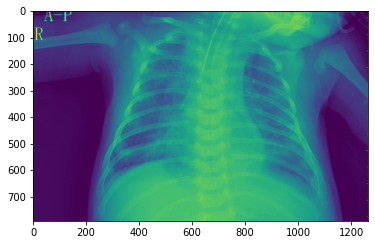

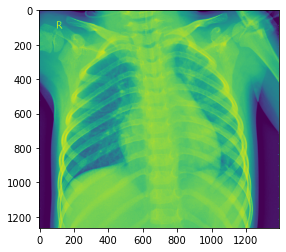

In [37]:
normal = mpimg.imread(imagePaths[0])
imgplot = plt.imshow(normal)
plt.show()

covid = mpimg.imread(imagePaths[16])
imgplot = plt.imshow(covid)
plt.show()

In [11]:
# perform one-hot encoding on labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
# train test split 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [13]:
trainAug = ImageDataGenerator(
    rotation_range=15, 
    fill_mode="nearest"
)

In [14]:
# model building
basemodel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# make all layers non trainable
for layer in basemodel.layers:
  layer.trainable = False

# head model 
average = AveragePooling2D(pool_size=(4,4))
flatten = Flatten()
dense_1 = Dense(64, activation='relu')
dropout = Dropout(0.5)
dense_2 = Dense(2, activation='softmax')

model = keras.Sequential([
                           basemodel,
                           average,
                           flatten, 
                           dense_1, 
                           dropout, 
                           dense_2
])

58892288/58889256 [==============================] - 0s 0us/step


In [15]:
# compile model
print('[INFO compiling model...')
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

[INFO compiling model...


In [17]:
# fit model and train
print('[INFO training model...')
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

[INFO training model.../n
Epoch 1/25
5/5 [==============================] - 1s 121ms/step - loss: 0.3908 - accuracy: 0.9750 - val_loss: 0.4601 - val_accuracy: 0.8000
Epoch 2/25
5/5 [==============================] - 0s 110ms/step - loss: 0.3664 - accuracy: 0.9750 - val_loss: 0.4559 - val_accuracy: 0.8000
Epoch 3/25
5/5 [==============================] - 0s 110ms/step - loss: 0.4382 - accuracy: 0.8750 - val_loss: 0.4573 - val_accuracy: 0.9000
Epoch 4/25
5/5 [==============================] - 0s 110ms/step - loss: 0.4076 - accuracy: 0.8500 - val_loss: 0.4534 - val_accuracy: 0.9000
Epoch 5/25
5/5 [==============================] - 0s 105ms/step - loss: 0.3595 - accuracy: 0.9500 - val_loss: 0.4365 - val_accuracy: 0.9000
Epoch 6/25
5/5 [==============================] - 0s 109ms/step - loss: 0.3268 - accuracy: 0.9500 - val_loss: 0.4160 - val_accuracy: 0.8000
Epoch 7/25
5/5 [==============================] - 0s 110ms/step - loss: 0.4012 - accuracy: 0.8250 - val_loss: 0.4119 - val_accuracy: 0

Classification Report

In [19]:
# evaluate model 
print("[INFO] evaluating network...")
# make predictions on test set
ypred = model.predict(testX, batch_size=BS)

# get largest predicted probability 
ypred = np.argmax(ypred, axis=1)

# classification report 
print(classification_report(testY.argmax(axis=1), ypred, target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      0.80      0.89         5
      normal       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



Metrics

In [20]:
# confusion matrix 
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# print 
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [0 5]]
acc: 0.9000
sensitivity: 0.8000
specificity: 1.0000


Plotting

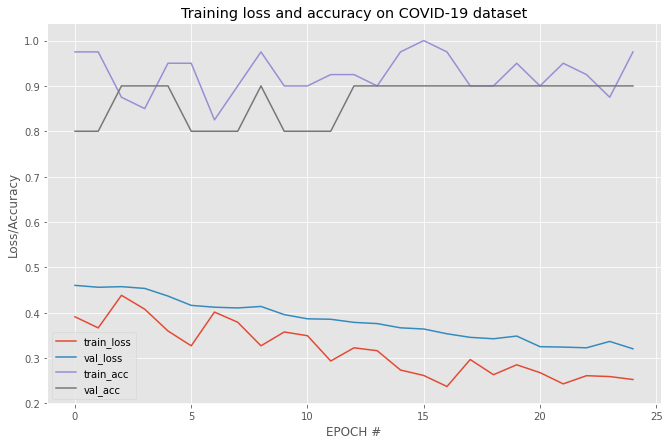

In [45]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(11, 7))
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title("Training loss and accuracy on COVID-19 dataset")
plt.xlabel("EPOCH #")
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(args['plot'])